# Problem set 7: Solving the consumer problem with income risk

In [9]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Tasks

Solving the consumer problem is the **primary task** in this exercise set. You should spend most of the time you have on testing that you understand the different optimizers (problem I) and on solving the intertemporal consumption model (problem III). If for instance you are stuck in plotting, then skip ahead.   

## Optimization problem I

Consider the function

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) = (x_1^2 - x_1x_2 + x_2^2)^2
$$

Define it in **sympy** by:

In [10]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (x1**2 - x1*x2 + x2**2)**2

The **Jacobian** is

In [11]:
f1 = sm.diff(f,x1)
f2 = sm.diff(f,x2)
sm.Matrix([f1,f2])

Matrix([
[ (4*x_1 - 2*x_2)*(x_1**2 - x_1*x_2 + x_2**2)],
[(-2*x_1 + 4*x_2)*(x_1**2 - x_1*x_2 + x_2**2)]])

The **Hessian**  is

In [12]:
f11 = sm.diff(f,x1,x1)
f12 = sm.diff(f,x1,x2)
f21 = sm.diff(f,x2,x1)
f22 = sm.diff(f,x2,x2)
sm.Matrix([[f11,f12],[f21,f22]])

Matrix([
[      2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (2*x_1 - x_2)**2), 2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2))],
[2*(-x_1**2 + x_1*x_2 - x_2**2 - (x_1 - 2*x_2)*(2*x_1 - x_2)),       2*(2*x_1**2 - 2*x_1*x_2 + 2*x_2**2 + (x_1 - 2*x_2)**2)]])

**Question A:** Lambdify $f(x_1,x_2)$ and use it to create: 

$(i)$ a 3D surfaceplot looking like this:

<img src="surfaceplot.png" 
     width="400" 
     height="500" />

$(ii)$ a contourplot looking like: 

<img src="contourplot.png" 
     width="400" 
     height="500" />

In [13]:
_f = sm.lambdify((x1,x2),f)


Similar plots are created in the notebook '3 - Unconstrained optimization'

/Users/luistm/.virtualenvs/cphcourses/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


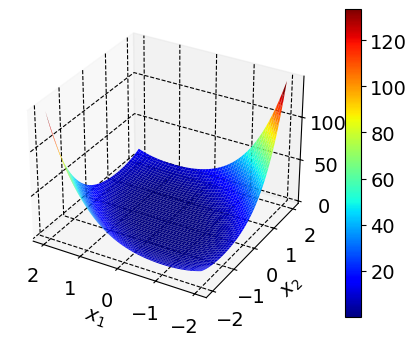

In [14]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure(dpi = 100, figsize=(7,4))
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

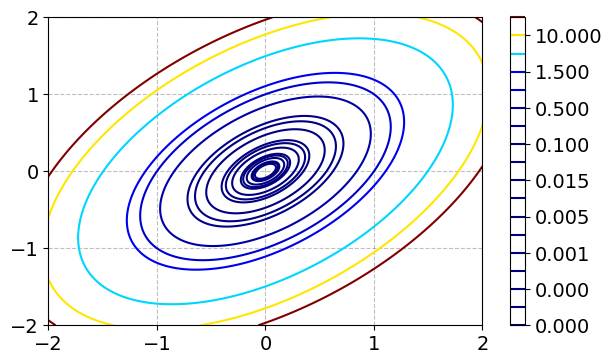

In [15]:
fig = plt.figure(dpi = 100, figsize=(7,4))
ax = fig.add_subplot(1,1,1)
levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Answer:** A1.py and A2.py

**Question B:** Construct python functions for the jacobian and the hessian.

In [16]:
f_python = lambda x: _f(x[0],x[1])

_f1 = sm.lambdify((x1,x2),f1)
_f2 = sm.lambdify((x1,x2),f2)
_f11 = sm.lambdify((x1,x2),f11)
_f12 = sm.lambdify((x1,x2),f12)
_f21 = sm.lambdify((x1,x2),f21)
_f22 = sm.lambdify((x1,x2),f22)

def f_jac(x):
    return np.array([_f1(x[0],x[1]),_f2(x[0],x[1])])

def f_hess(x):
    row1 = [_f11(x[0],x[1]),_f12(x[0],x[1])]
    row2 = [_f21(x[0],x[1]),_f22(x[0],x[1])]
    return np.array([row1,row2])


**Answer:** A3.py

**Question C:** Minimize $f(x_1,x_2)$ using respectively

1. Nelder-Mead,
2. BFGS without analytical jacobian,
3. BFGS with analytical jacobian, and
4. Newton-CG with analytical jacobian and hessian

Compare the results and discuss which optimizer you prefer.

**Optional:** If you wish, you can use the functions defined in the hidden cells below to also track how the optimizers converges to the solution.

In [17]:
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [f_python(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(f_python(x))
    
    # c. increment number of evaluations
    evals += 1

In [18]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
    cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 83


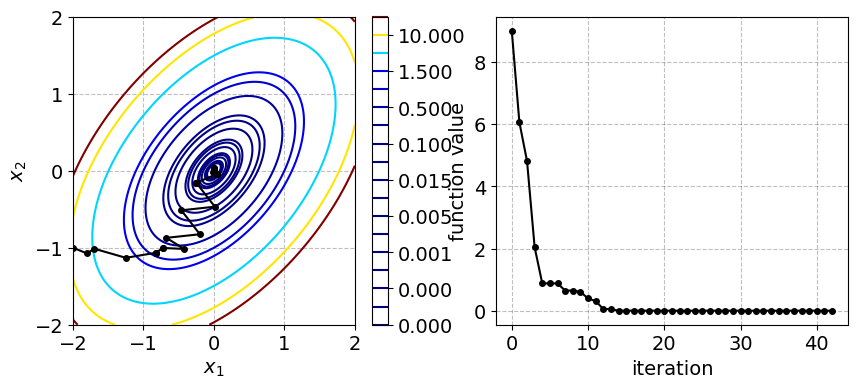

In [19]:
x0 = [-2,-1] # suggested initial guess

evals = 0
result = optimize.minimize(f_python,x0,
                           method='Nelder-Mead',
                           callback=collect, # call function collect() before each iteration
                           options={'disp':True}) # display the results
contour()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 84
         Gradient evaluations: 28


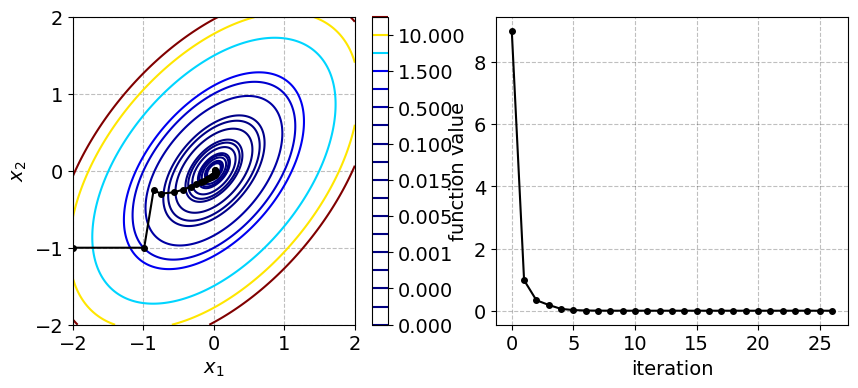

In [20]:
evals = 0 # global used in "collect"

result = optimize.minimize(f_python,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28


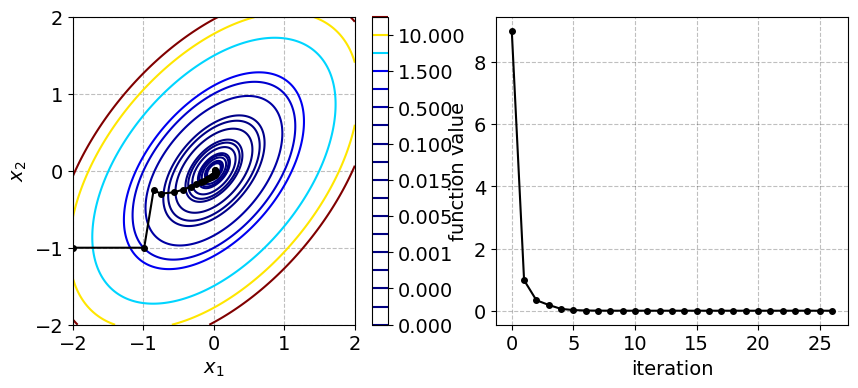

In [21]:
evals = 0 # global used in "collect"

result = optimize.minimize(f_python,x0,jac=f_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 15
         Gradient evaluations: 15
         Hessian evaluations: 15


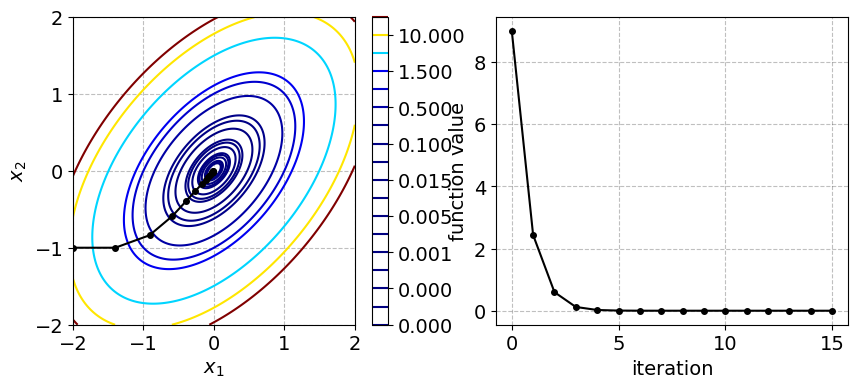

In [22]:
evals = 0 # global used in "collect"

result = optimize.minimize(f_python,x0,jac=f_jac,hess=f_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

**Answer:** A4.py, A5.py, A6.py, A7.py

## Optimization problem II

Consider the function

$$
f(x_1,x_2) = (4-2.1x_1^2 + \frac{x_1^4}{3})x_1^2 + x_1x_2 + (4x_2^2 - 4)x_2^2)
$$

Define it in **sympy** by:

In [23]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
_f = sm.lambdify((x1,x2),f)
f

x_1**2*(x_1**4/3 - 2.1*x_1**2 + 4) + x_1*x_2 + x_2**2*(4*x_2**2 - 4)

Create **3D plot**:

/Users/luistm/.virtualenvs/cphcourses/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


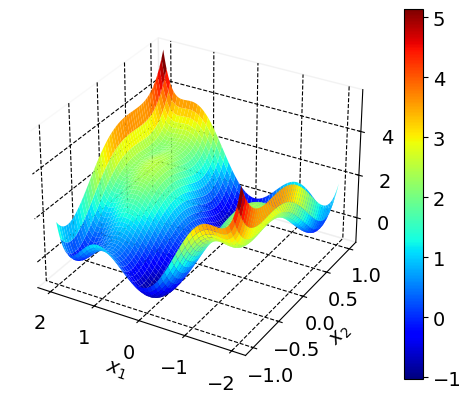

In [24]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-1,1,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Question A:** Find the minimum of the function starting from each of the suggested initial values below. Print the first 20 solutions, and all solutions aftwards, which is the best yet to be found. Save the solutions and associated function values in `xs` and `fs`.

In [25]:
# a. python function for f
f_python = lambda x: _f(x[0],x[1])

# b. initial guesses
np.random.seed(1986)
K = 1000
x0s = np.empty((K,2))
x0s[:,0] = -2 + 4*np.random.uniform(size=K)
x0s[:,1] = -1 + 2*np.random.uniform(size=K)

# c. solutions and associated values
xs = np.empty((K,2))
fs = np.empty(K)

# write your code here

This is also very similar to code in '3 - Unconstrained optimization'

In [18]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(f_python,x0,method='BFGS',tol=1e-8)
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 20 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:7.2f},{x0[1]:7.2f})',end='')
        print(f' -> converged at ({xs[i][0]:7.2f},{xs[i][1]:7.2f}) with f = {f:12.8f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')

   0: x0 = (   0.28,  -0.58) -> converged at (   0.09,  -0.71) with f =  -1.03162845
   1: x0 = (  -1.69,  -0.97) -> converged at (  -1.70,   0.80) with f =  -0.21546382
   2: x0 = (   0.43,  -0.80) -> converged at (   0.09,  -0.71) with f =  -1.03162845
   3: x0 = (   1.59,   0.70) -> converged at (   1.70,  -0.80) with f =  -0.21546382
   4: x0 = (   0.18,  -0.25) -> converged at (   0.09,  -0.71) with f =  -1.03162845
   5: x0 = (   0.81,   0.51) -> converged at (  -0.09,   0.71) with f =  -1.03162845
   6: x0 = (  -0.46,   0.41) -> converged at (  -0.09,   0.71) with f =  -1.03162845
   7: x0 = (   0.61,  -0.89) -> converged at (   0.09,  -0.71) with f =  -1.03162845
   8: x0 = (   0.76,   0.66) -> converged at (  -0.09,   0.71) with f =  -1.03162845
   9: x0 = (   0.87,   0.53) -> converged at (  -0.09,   0.71) with f =  -1.03162845
  10: x0 = (   0.76,   0.14) -> converged at (  -0.09,   0.71) with f =  -1.03162845
  11: x0 = (   1.23,   0.11) -> converged at (   1.70,  -0.80) wi

**Answer:** A8.py

**Question B:** Create a 3D scatter plot of where the optimizer converges, and color the dots by the associated function values.

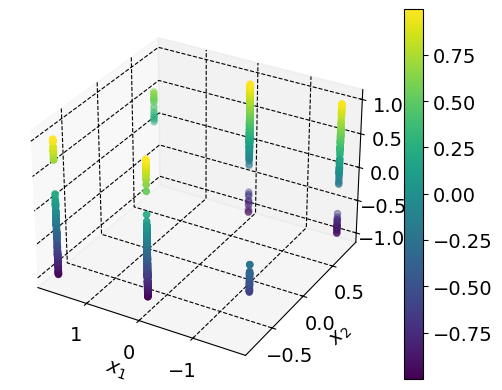

In [19]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(xs[:,0],xs[:,1],fs,c=fs);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

**Answer:** A9.py

**Question C:** Plot the function values at the solutions as a function of the starting values.

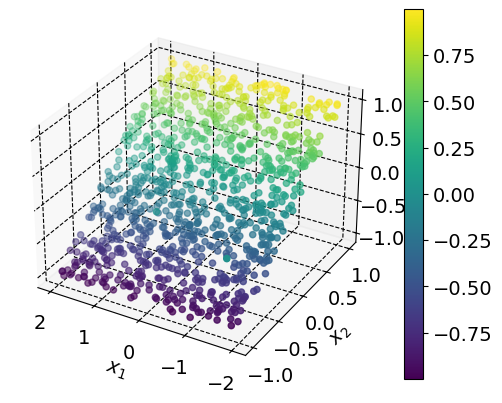

In [20]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x0s[:,0],x0s[:,1],fs,c=fs);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

**Answer:** A10.py

# Problem: Solve the consumer problem with income risk I

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

The **basic functions** are:

In [26]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

The **solution functions** are:

In [27]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-8,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x[0]
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1/2
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-12,m1),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec

**Question A:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it.

Follows code from '3 - Dynamic optimization', I've put it into a class

In [28]:
%load_ext autoreload
%autoreload 2
from ConsumerModel import ConsumerModelClass

In [29]:
CM = ConsumerModelClass()

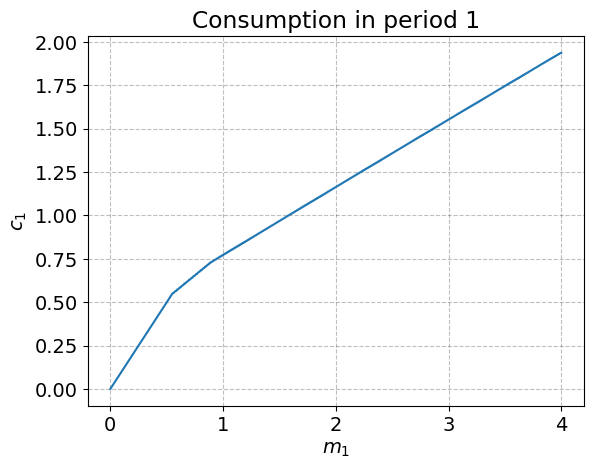

In [30]:
CM.solve()
CM.plot_c1()

**Question B:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it, assuming that

$$ 
y_{2} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}
$$

which add some low probability tail events, but does not change mean income. Give an interpretation of the change in the consumption function.

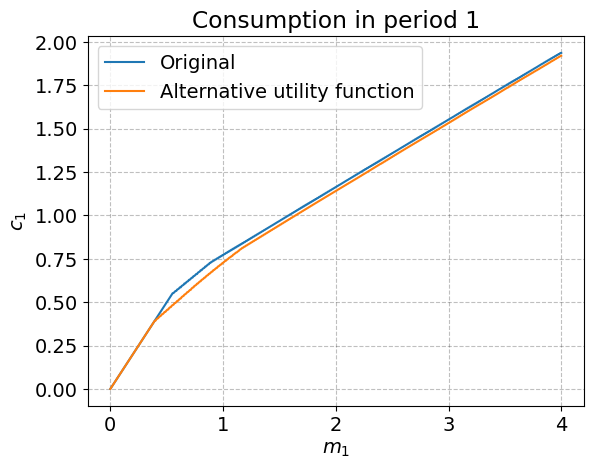

In [31]:
CM.plot_c1(add_alt=True)

# Problem: Solve the consumer problem with income risk II

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

Choose **parameters**:

In [32]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

**Question A:** Solve for consumption in period 2 and plot the consumption function.

In [33]:
from ConsumerModel2 import ConsumerModelClass2

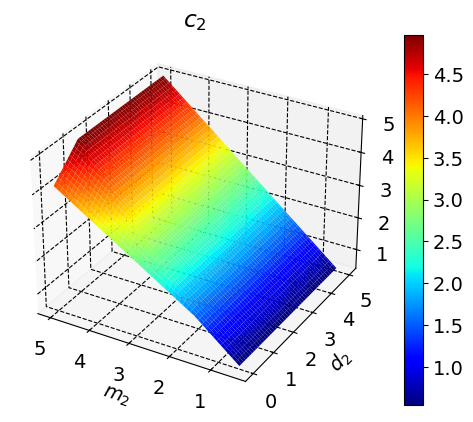

In [34]:
CM2 = ConsumerModelClass2()
CM2.solve_period_2()
CM2.plot_c2()

**Question B:** Find optimal consumption and choices of durables in the first period as a function of cash-on-hand and plot it.

In [35]:
CM2.solve_period_2()

In [36]:
sol = CM2.sol
par = CM2.par

In [37]:
sol.v2_interp = interpolate.RegularGridInterpolator((sol.m2_vec,sol.d2_vec), sol.v2_grid,
                                                    bounds_error=False,fill_value=None)

/Users/luistm/.virtualenvs/cphcourses/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


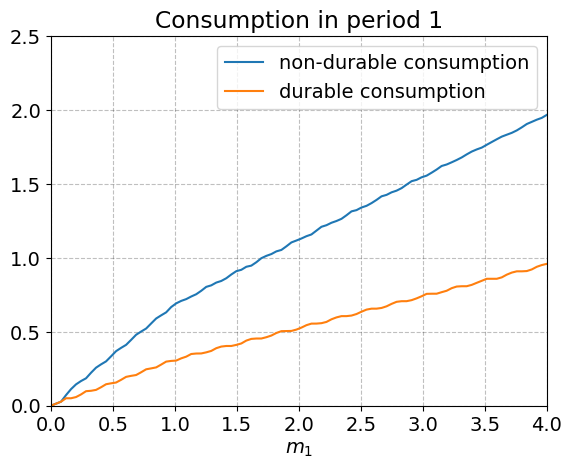

In [38]:
CM2.solve()
CM2.plot_c1()

# Extra Problems

**Simulate** a distribution of consumers in either of the two consumption-saving models above. See the notebook **3 - Dynamic optimization** for how this is done.

In [39]:
# This step is very fast because we already have the solution
CM2.simulate()

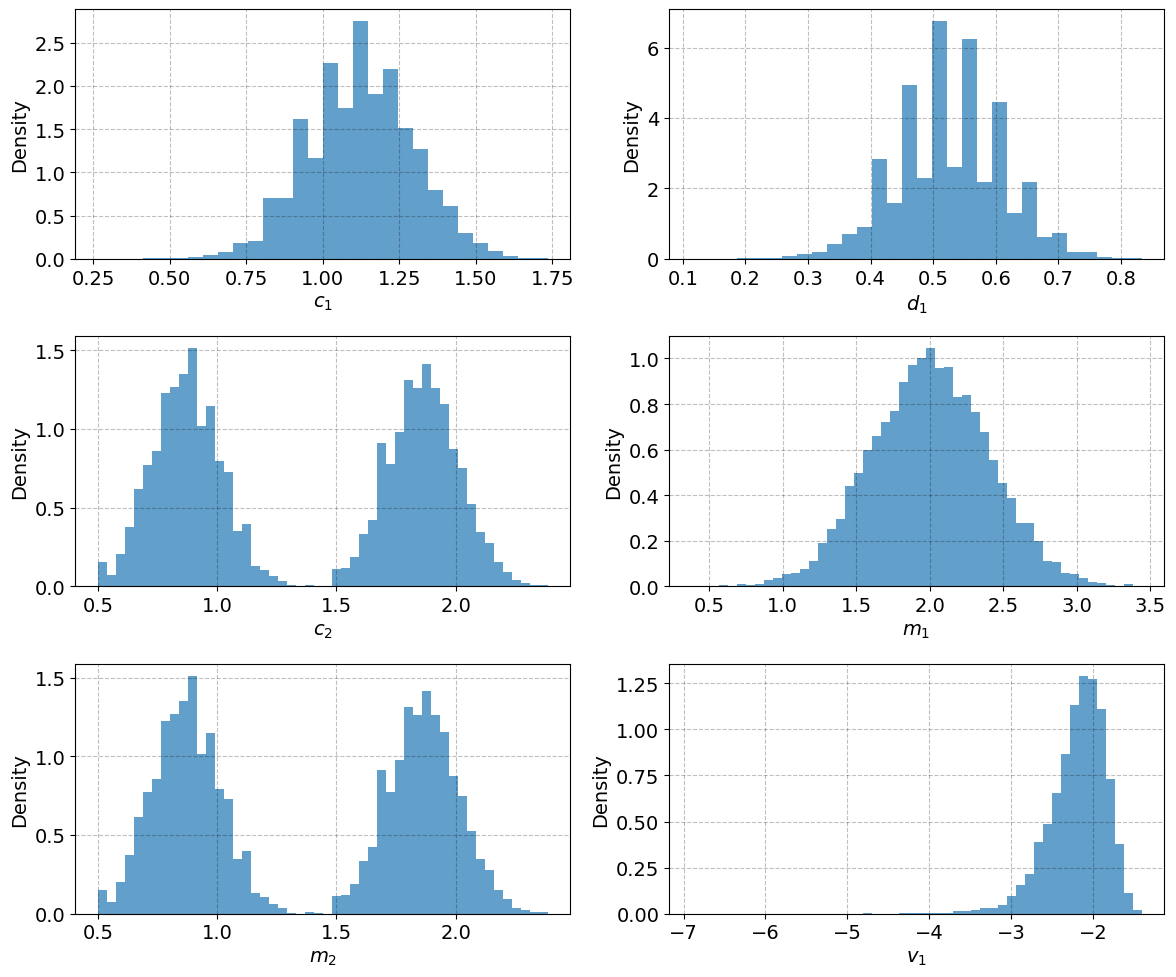

In [40]:
axes = CM2.plot_simulation()

In [41]:
# More precise version
precision = {'m2N':300,'m1N':200,'d2N':200,'simn':100_000}
CM2_large = ConsumerModelClass2(**precision)
CM2_large.solve()
CM2_large.draw_shocks(seed=105)
CM2_large.simulate()

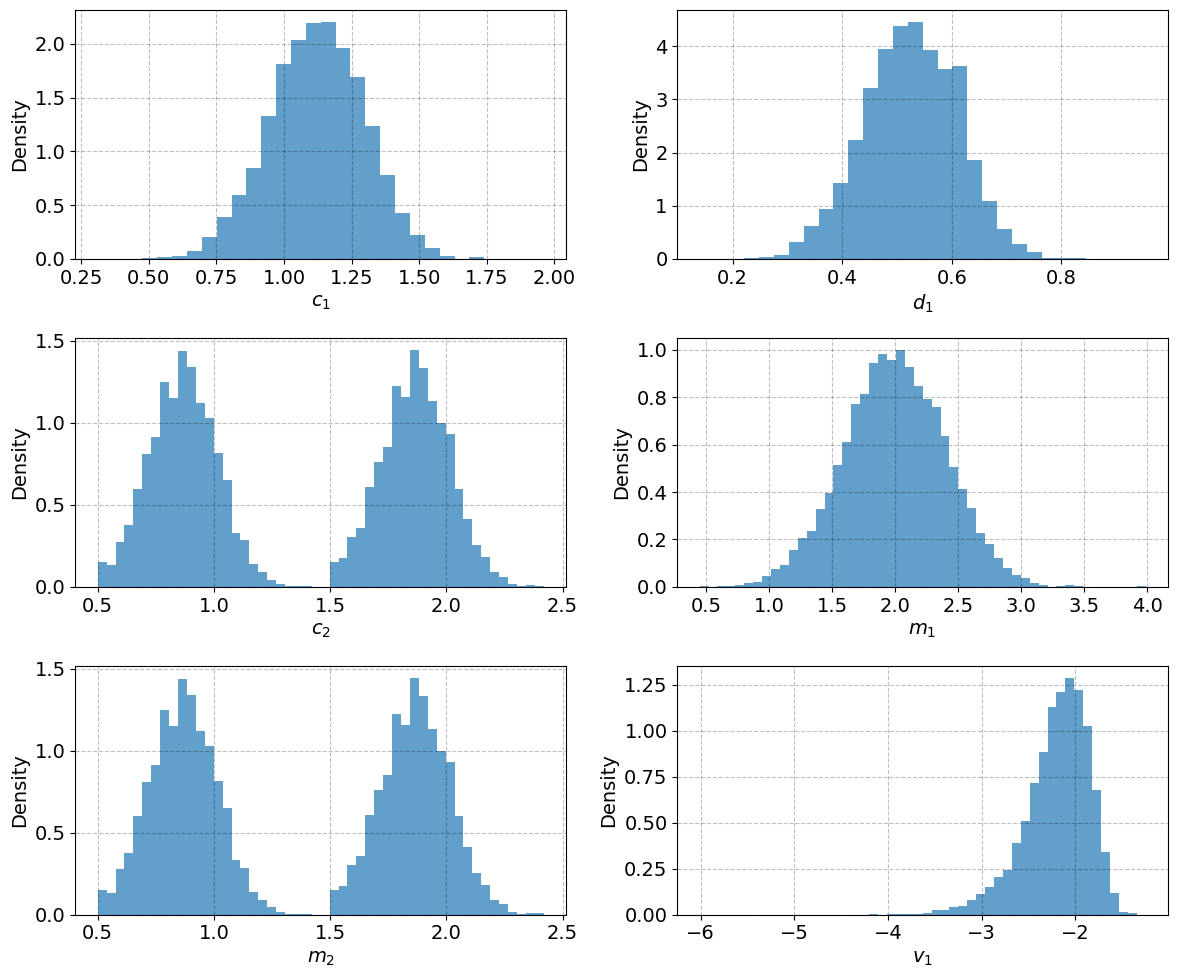

In [42]:
axes = CM2_large.plot_simulation(label='$r=0.04$')

In [43]:
# How does chaning alpha to 0.4 change the distribution?
CM2_alpha = ConsumerModelClass2(alpha=0.4,**precision)
CM2_alpha.solve()
CM2_alpha.draw_shocks(seed=105) # Because seed is the same along with sizes, shocks are the same
CM2_alpha.simulate()

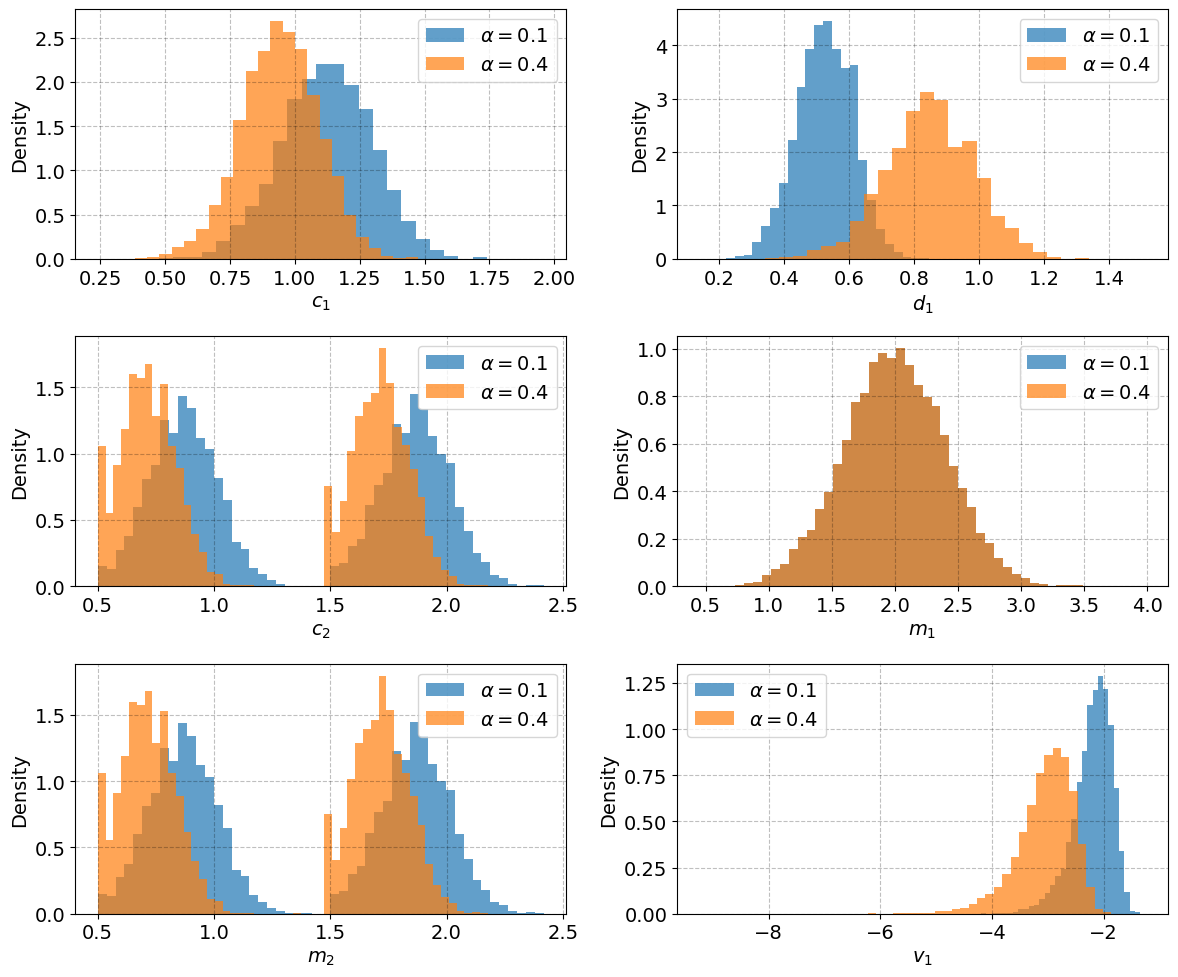

In [44]:
axes = CM2_large.plot_simulation(label=r'$ \alpha = 0.1$')
axes = CM2_alpha.plot_simulation(label=r'$ \alpha =0.4$', axes=axes)
for ax in axes.flatten():
    ax.legend()

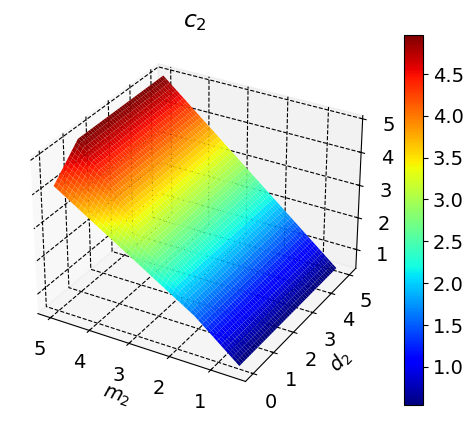

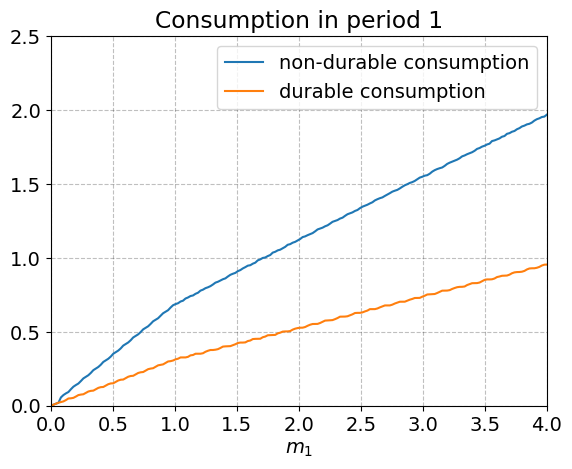

In [45]:
CM2_large.plot_c2()
CM2_large.plot_c1()

In [46]:
# How does chaning nu to 0.5 change the distribution?
CM2_nu = ConsumerModelClass2(nu=0.5,**precision)
CM2_nu.solve()
CM2_nu.draw_shocks(seed=105) # Because seed is the same along with sizes, shocks are the same
CM2_nu.simulate()

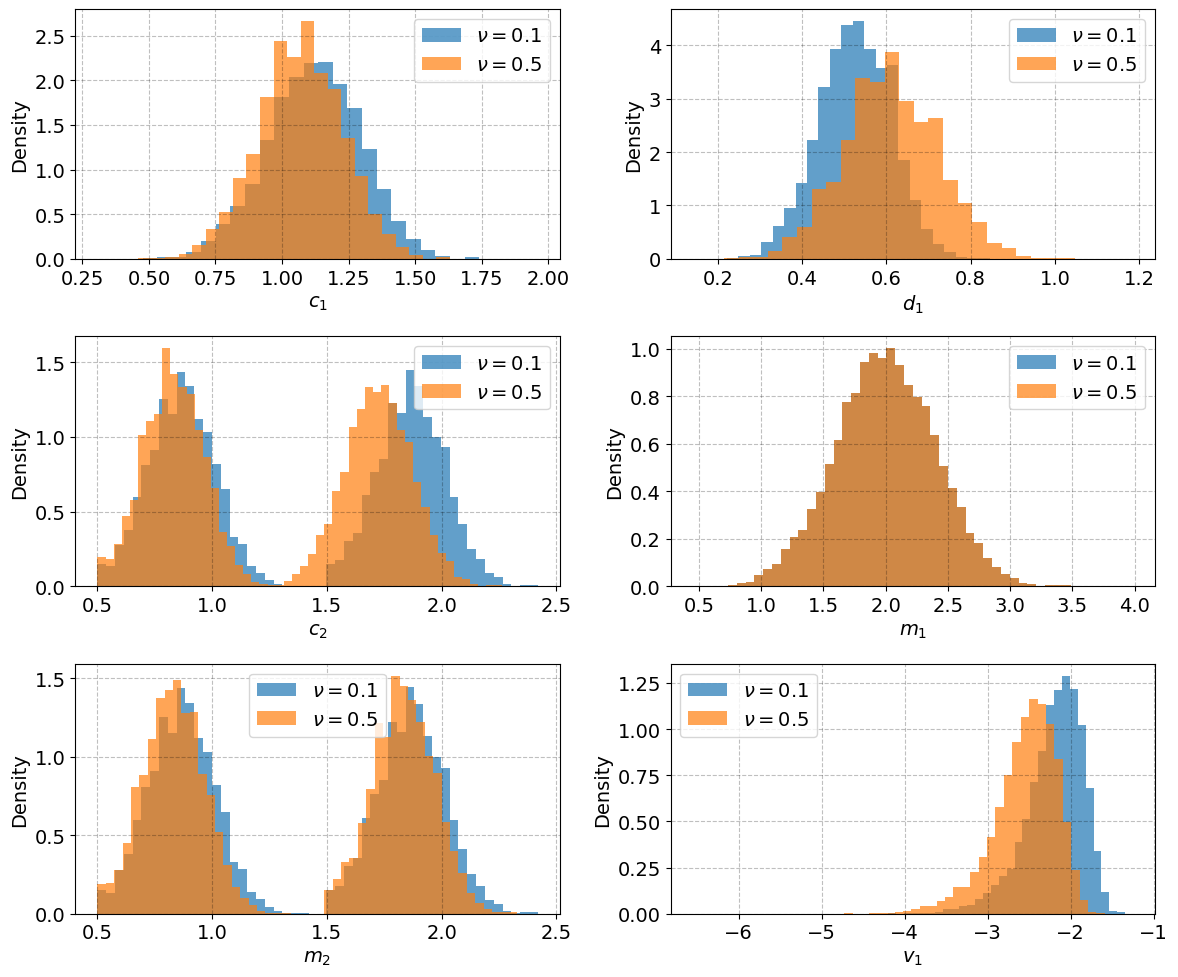

In [47]:
axes = CM2_large.plot_simulation(label=r'$ \nu = 0.1$')
axes = CM2_nu.plot_simulation(label=r'$ \nu =0.5$', axes=axes)
for ax in axes.flatten():
    ax.legend()

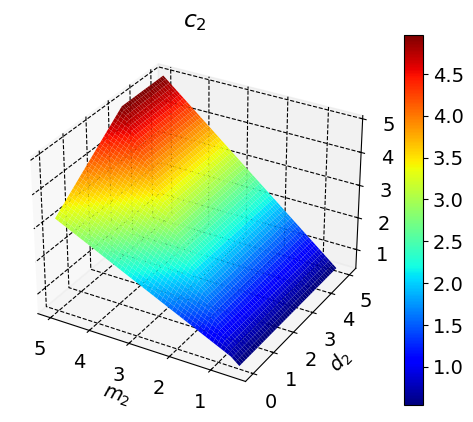

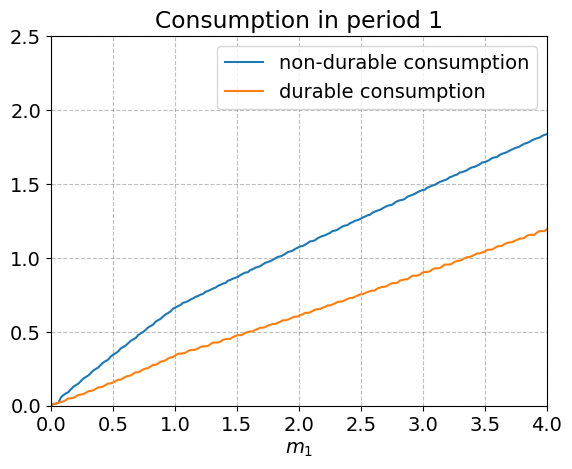

In [48]:
CM2_nu.plot_c2()
CM2_nu.plot_c1()